In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm

In [2]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max):
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree>=k_min) and (random_degree<=k_max)):
                break
            
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, sigma, degree):
    n = degree.size
    p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
    p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size)
                flag= flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i]-degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
                p_value = np.random.random()*p_max
                p[i][int(degree_clone[i]-degree[i])] = p_value
                p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix, p

@jit(nopython = True)
def sigma_check(p):
    sigma = np.zeros(p.shape[0])
    for i in range(p.shape[0]):
        sigma[i] = p[i].sum()
    return sigma

In [3]:
N = 10**6
K = 10
k_min = 2
k_max = N - 1
sigma = 1.8
degree = Degree_generate_homo(N, K, k_min, k_max)
degree_clone = degree.copy()
network_connection, p  = network_generate(K, sigma, degree_clone)

In [4]:
print(degree.max())
p_clone = np.copy(p)
sigma_i = sigma_check(p_clone)
print(p_clone.max())

28.0
0.35999985158122705


Text(0.5, 1.0, 'N($\\sigma_i$) vs degree')

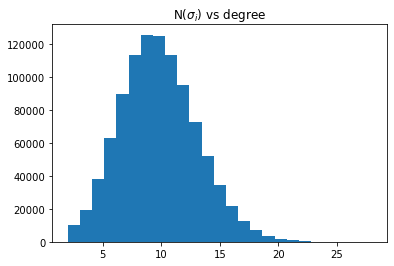

In [5]:
plt.hist(degree,25)
plt.title('N($\sigma_i$) vs degree')


Text(0.5, 1.0, '$\\sigma_i$ vs N($\\sigma_i$)')

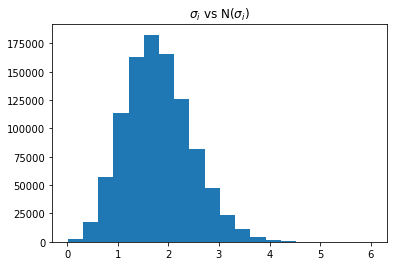

In [6]:
plt.hist(sigma_i,20)
plt.title('$\sigma_i$ vs N($\sigma_i$)')


In [7]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0

###   internal(neural) stimulus   ###
@jit(nopython = True)
def internal(p, index_matrix, index, state_matrix, degree):
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1):
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [8]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

Time cost: 20.55949091911316


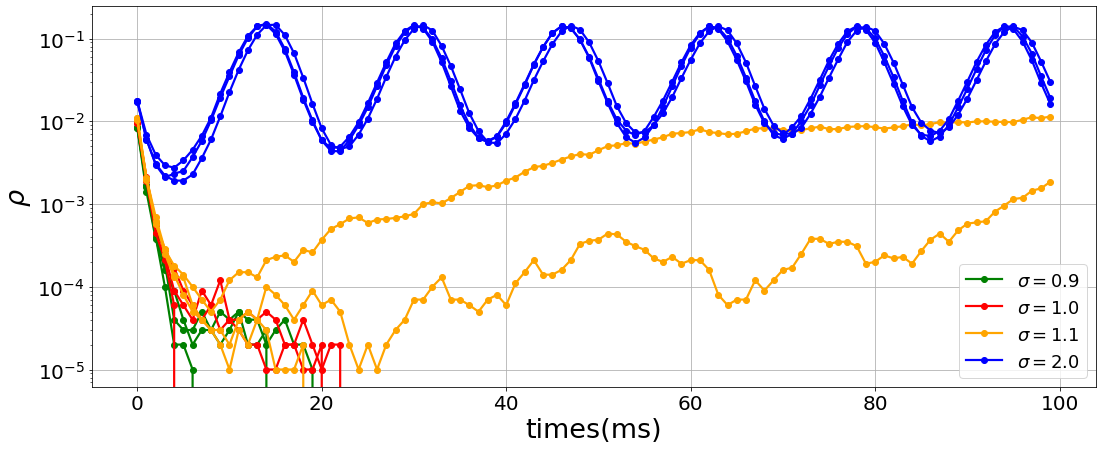

In [9]:
start_i = time.time()
state_num_list = [5,10]
sigma_list = [0.9, 1.0, 1.1, 2.0]
color = ['green', 'red', 'orange', 'blue']
r = 0.0
times = 100
fig, ax = plt.subplots(figsize=(18, 7))
t_test = np.arange(times)
for i in range (12):
    sigma = sigma_list[i//3]    
    N = 10**5
    K = 10
    k_min = 2
    k_max = N - 1
    n = state_num_list[1]
    degree = Degree_generate_homo(N, K, k_min, k_max)
    degree_clone = degree.copy()
    network_connection, p  = network_generate(K, sigma, degree_clone)
    rho_test = KC_model(degree, network_connection, p, 0, times, r, times, n)
    if(i%3):
        ax.plot(t_test, rho_test, marker = 'o', color = color[i//3], linewidth=2.2, linestyle='-')
    else:
        ax.plot(t_test, rho_test, marker = 'o', color = color[i//3], linewidth=2.2, linestyle='-'\
                , label = '$\sigma=%.1f$'%(sigma))
ax.set_xlabel('times(ms)',fontsize=27)
ax.set_ylabel('$\\rho$',fontsize=27)
# ax.set_title('Activity test',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()
print('Time cost:', time.time()-start_i)

In [10]:
@jit(nopython = True)
def main_function(sigma, N):
    K = 10
    F0 = []
    for sti in range(0, 120):
        degree = Degree_generate_homo(N, K, 1, N - 1)
        degree_clone = degree.copy()
        network_connection, p  = network_generate(K, sigma, degree_clone)
        rho_test = KC_model(degree, network_connection, p, 0, 800, 10**((sti/20)-5), 1000, 5)
        F0.append(F0_determine(rho_test, T_min = 500, T_max = 800))
    return F0
@jit(nopython = True)
def multi_compute(sigma):
    F0 = main_function(sigma, 10**(5))
    return F0

In [15]:
pool = mp.Pool(processes = 11)
test_result = []
start_i = time.time()
with mp.Pool(processes = 11) as pool:
    for i in range(11):
        with tqdm(total=33) as pbar:
            test_banch = np.array([i/5 for j in range(33)])
            result = []
            for k, a in enumerate(pool.imap_unordered(multi_compute, test_banch)):
                result.append(a)
                pbar.update(1)
            test_result.append(result)
        print(i/5, 'finished')
print('Time cost:', time.time()-start_i)

100%|██████████| 33/33 [2:11:06<00:00, 238.38s/it]  


0.0 finished


100%|██████████| 33/33 [2:07:52<00:00, 232.49s/it]  


0.2 finished


100%|██████████| 33/33 [2:07:53<00:00, 232.53s/it]  


0.4 finished


100%|██████████| 33/33 [2:08:04<00:00, 232.88s/it]  


0.6 finished


100%|██████████| 33/33 [2:08:22<00:00, 233.42s/it]  


0.8 finished


100%|██████████| 33/33 [2:09:58<00:00, 236.33s/it]  


1.0 finished


100%|██████████| 33/33 [2:29:09<00:00, 271.21s/it]  


1.2 finished


100%|██████████| 33/33 [2:25:13<00:00, 264.05s/it]  


1.4 finished


100%|██████████| 33/33 [2:30:56<00:00, 274.45s/it]  


1.6 finished


100%|██████████| 33/33 [2:38:09<00:00, 287.57s/it]  


1.8 finished


100%|██████████| 33/33 [2:37:47<00:00, 286.88s/it]  

2.0 finished
Time cost: 92076.56370902061


In [11]:
test_result = np.load('dB_test_precise.npy')

In [12]:
###   ensemble   ###
ensemble_result = []
for i in range(11):
    ensemble = np.zeros(120)
    for j in range(120):
        temp_ensemble = 0
        for k in range(33):
            temp_ensemble += test_result[i][k][j]
        ensemble[j] = temp_ensemble/33
    ensemble_result.append(ensemble)

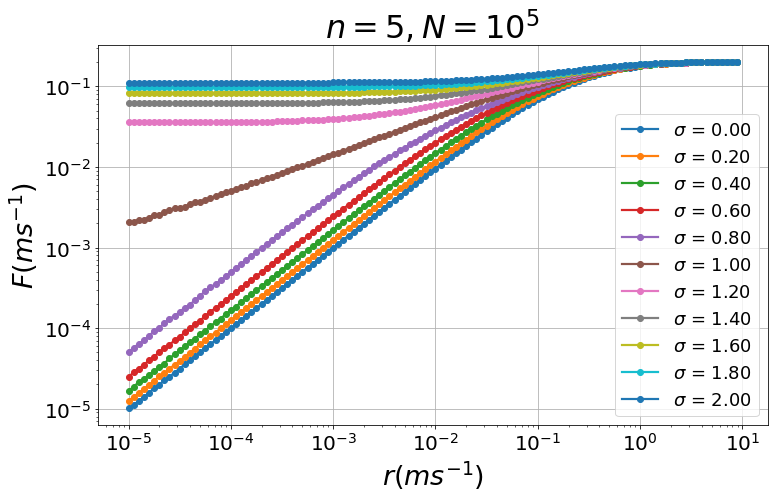

In [13]:
F0_test = [10**((i/20)-5) for i in range(0, 120)]
fig, ax = plt.subplots(figsize=(12, 7))
for sigma in range(11):
    ax.plot(F0_test, ensemble_result[sigma], linewidth=2.2, linestyle='-', marker = 'o', label = '$\sigma$ = %.2f'%(sigma/5))

ax.set_ylabel('$F(ms^{-1}$)',fontsize=27)
ax.set_xlabel('$r(ms^{-1})$',fontsize=27)
ax.set_title('$n = 5, N = 10^5$',fontsize=32)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()

In [14]:
# @jit(nopython=True)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

# @jit(nopython = True)
def dB_find(F0, base_line):
    F_00 = np.min(F0)
    F_10 = np.max(F0)
    F_01 = F_00 + (F_10 - F_00) * 0.1
    F_09 = F_00 + (F_10 - F_00) * 0.9
    index_min = find_nearest(F0, F_01)
    index_max = find_nearest(F0, F_09)
    return (10*np.log10(base_line[index_max]/base_line[index_min]))

In [15]:
dB = []
for sigma in range(11):
    dB.append(dB_find(ensemble_result[sigma], F0_test))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


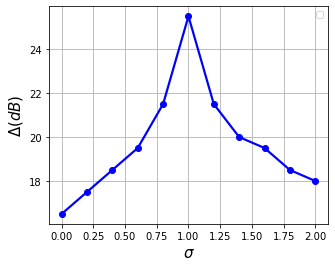

In [16]:
dB_test = [i/5 for i in range(11)]
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(dB_test, dB, color='blue', linewidth=2.2, linestyle='-', marker = 'o')

ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('$\Delta (dB)$',fontsize=15)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
font_prop = font_manager.FontProperties(size=9)
ax.legend(prop = font_prop)
plt.grid()

In [17]:
@jit(nopython = True)
def transistion_test(N):
    F0 = []
    r = 10**(-7)
    times = 1000
    state_num = 5
    K_min, K_mean, K_max = 1, 10, N-1

    for sigma in range(0, 5):
        degree = Degree_generate_homo(N, K_mean, K_min, K_max)
        degree_clone = degree.copy()
        network_connection, p  = network_generate(K_mean, sigma / 5 + 0.1, degree_clone)
        rho_test = KC_model(degree, network_connection, p, 0, times, r, times, state_num)
        F0.append(F0_determine(rho_test, T_min = 800, T_max = times))
        
    for sigma in range(0, 10):
        degree = Degree_generate_homo(N, K_mean, K_min, K_max)
        degree_clone = degree.copy()
        network_connection, p  = network_generate(K_mean, sigma / 50 + 0.9, degree_clone)
        rho_test = KC_model(degree, network_connection, p, 0, times, r, times, state_num)
        F0.append(F0_determine(rho_test, T_min = 800, T_max = times))
        
    for sigma in range(0, 18):
        degree = Degree_generate_homo(N, K_mean, K_min, K_max)
        degree_clone = degree.copy()
        network_connection, p  = network_generate(K_mean, sigma / 20 + 1.1, degree_clone)
        rho_test = KC_model(degree, network_connection, p, 0, times, r, times, state_num)
        F0.append(F0_determine(rho_test, T_min = 800, T_max = times))
    return F0

@jit(nopython = True)
def multi_compute_transistion_test(N):    
    F0 = transistion_test(N)
    return F0

In [21]:
pool = mp.Pool(processes = 10)
test_result = []
ensemble_times = 300
start_i = time.time()
with mp.Pool(processes = 10) as pool:
    for i in range(3, 4):
        with tqdm(total=ensemble_times) as pbar:
            test_banch = np.array([10**(i+2) for j in range(ensemble_times)])
            result = []
            for k, a in enumerate(pool.imap_unordered(multi_compute_transistion_test, test_banch)):
                result.append(a)
                pbar.update(1)
            test_result.append(result)
            print(10**(i+2), 'finished')
print('Time cost:', time.time()-start_i)

100%|██████████| 300/300 [5:38:33<00:00, 67.71s/it]    

100000 finished
Time cost: 20313.514219999313


In [21]:
test_result = np.load('KC_transition_test_n5.npy')

In [22]:
###   ensemble   ###
ensemble_result = []
for i in range(1):
    ensemble_times = len(test_result[i])
    ensemble = np.zeros(33)
    for j in range(33):
        temp_ensemble = 0
        for k in range(ensemble_times):
            temp_ensemble += test_result[i][k][j]
        ensemble[j] = temp_ensemble/ensemble_times
    ensemble_result.append(ensemble)

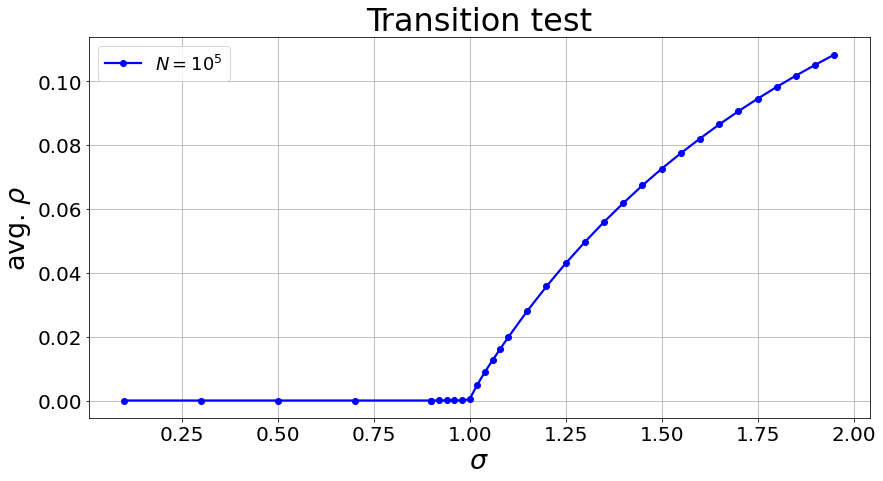

In [23]:
test_banch = [(i / 5) + 0.1 for i in range(5)]
for i in range(10):
    test_banch.append(i/50 + 0.9)
for i in range(18):
    test_banch.append(i/20 + 1.1)
    
fig, ax = plt.subplots(figsize=(14, 7))
for N in range(1):
    ax.plot(test_banch, ensemble_result[N], color = 'blue', linewidth=2.2, linestyle='-', marker = 'o', label = '$N = 10^{%d}$'%(5))

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize=27)
ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)
plt.grid()